In [ ]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')


modules loaded


In [ ]:
train_dir = '/content/drive/MyDrive/parent_dir/train'
filepaths = []
labels = []

folds = os.listdir(train_dir)
for fold in folds:
    foldpath = os.path.join(train_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
train_df

,filepaths,labels
0,/content/drive/MyDrive/parent_dir/train/nike/2...,nike
1,/content/drive/MyDrive/parent_dir/train/nike/8...,nike
2,/content/drive/MyDrive/parent_dir/train/nike/2...,nike
3,/content/drive/MyDrive/parent_dir/train/nike/2...,nike
4,/content/drive/MyDrive/parent_dir/train/nike/9...,nike
...,...,...
706,/content/drive/MyDrive/parent_dir/train/adidas...,adidas
707,/content/drive/MyDrive/parent_dir/train/adidas...,adidas
708,/content/drive/MyDrive/parent_dir/train/adidas...,adidas
709,/content/drive/MyDrive/parent_dir/train/adidas...,adidas


In [ ]:
test_dir = '/content/drive/MyDrive/parent_dir/test'
filepaths = []
labels = []

folds = os.listdir(test_dir)
for fold in folds:
    foldpath = os.path.join(test_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)


In [ ]:
test_df

,filepaths,labels
0,/content/drive/MyDrive/parent_dir/test/nike/19...,nike
1,/content/drive/MyDrive/parent_dir/test/nike/17...,nike
2,/content/drive/MyDrive/parent_dir/test/nike/21...,nike
3,/content/drive/MyDrive/parent_dir/test/nike/9.jpg,nike
4,/content/drive/MyDrive/parent_dir/test/nike/36...,nike
...,...,...
109,/content/drive/MyDrive/parent_dir/test/convers...,converse
110,/content/drive/MyDrive/parent_dir/test/convers...,converse
111,/content/drive/MyDrive/parent_dir/test/convers...,converse
112,/content/drive/MyDrive/parent_dir/test/convers...,converse


In [ ]:
valid_df, test_df = train_test_split(test_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [ ]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 711 validated image filenames belonging to 3 classes.
Found 68 validated image filenames belonging to 3 classes.
Found 46 validated image filenames belonging to 3 classes.


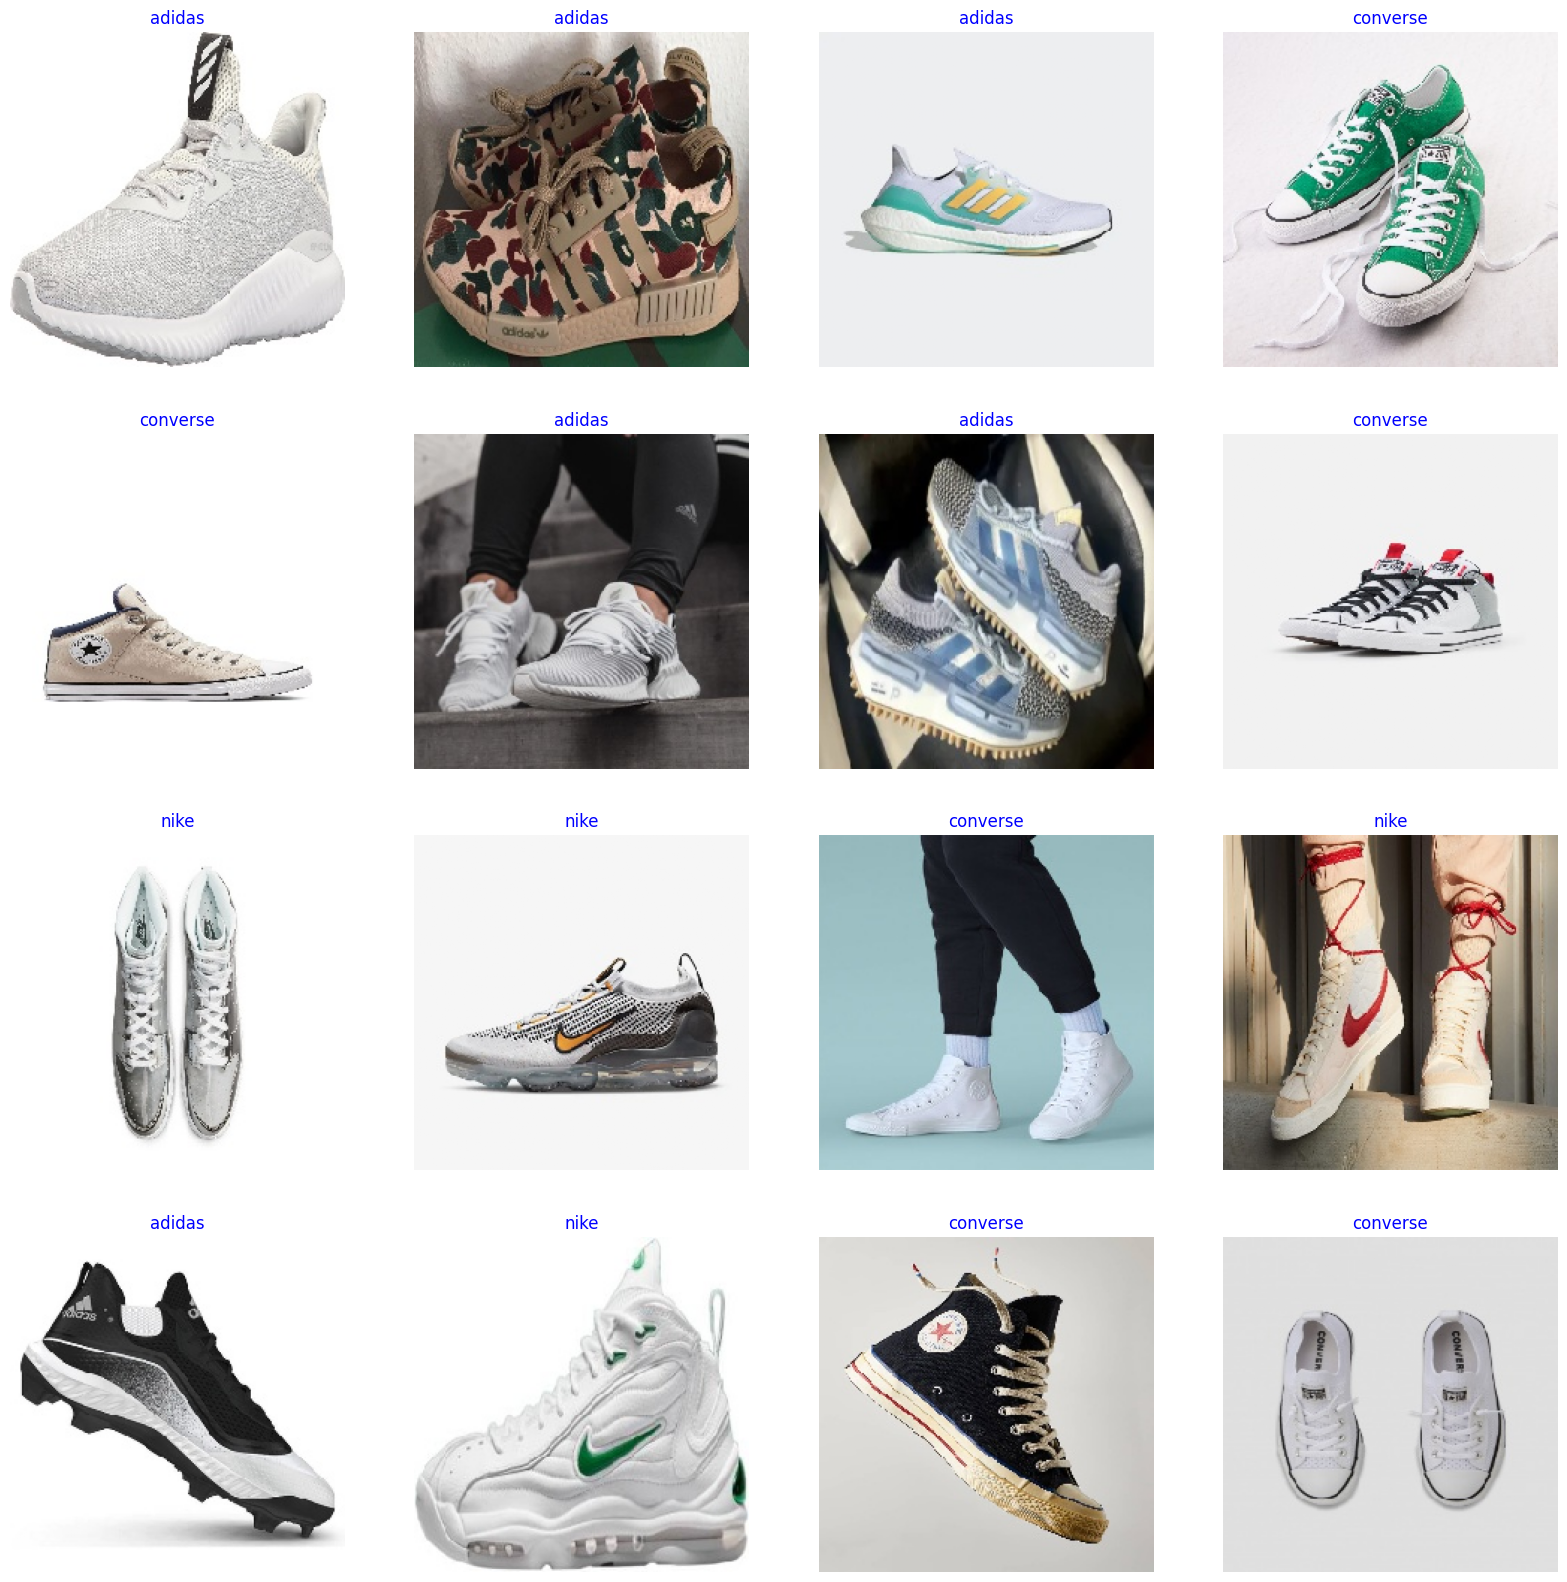

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers

# Clear any previous models to reset the session
tf.keras.backend.clear_session()

# Model structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # Number of classes in dense layer

# Create pre-trained model using EfficientNetB0
base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
# base_model.trainable = False

model = Sequential([
    Input(shape=img_shape),
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256,
          kernel_regularizer=regularizers.l2(0.016),  # Corrected l to lambda
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006),
          activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,383,398 (16.72 MB)

 Trainable params: 4,338,815 (16.55 MB)

 Non-trainable params: 44,583 (174.16 KB)

In [ ]:
batch_size = 20   # set batch size for training
epochs =  20  # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 276s 5s/step - accuracy: 0.4681 - loss: 17.6072 - val_accuracy: 0.5882 - val_loss: 22.2775
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 206s 5s/step - accuracy: 0.4597 - loss: 8.4485 - val_accuracy: 0.4706 - val_loss: 11.9975
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - accuracy: 0.3846 - loss: 7.1151 - val_accuracy: 0.3971 - val_loss: 8.7247
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 263s 5s/step - accuracy: 0.3507 - loss: 6.6894 - val_accuracy: 0.3971 - val_loss: 7.1172
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 261s 5s/step - accuracy: 0.3540 - loss: 6.4079 - val_accuracy: 0.3971 - val_loss: 6.5218
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 198s 4s/step - accuracy: 0.3607 - loss: 6.0960 - val_accuracy: 0.4118 - val_loss: 5.9375
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 197s 4s/step - accuracy: 0.3196 - loss: 5.8409 - val_accuracy: 0.3824 - val_loss: 5.6139
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.3320 - loss: 5.5449 - val_accuracy: 0.3676 

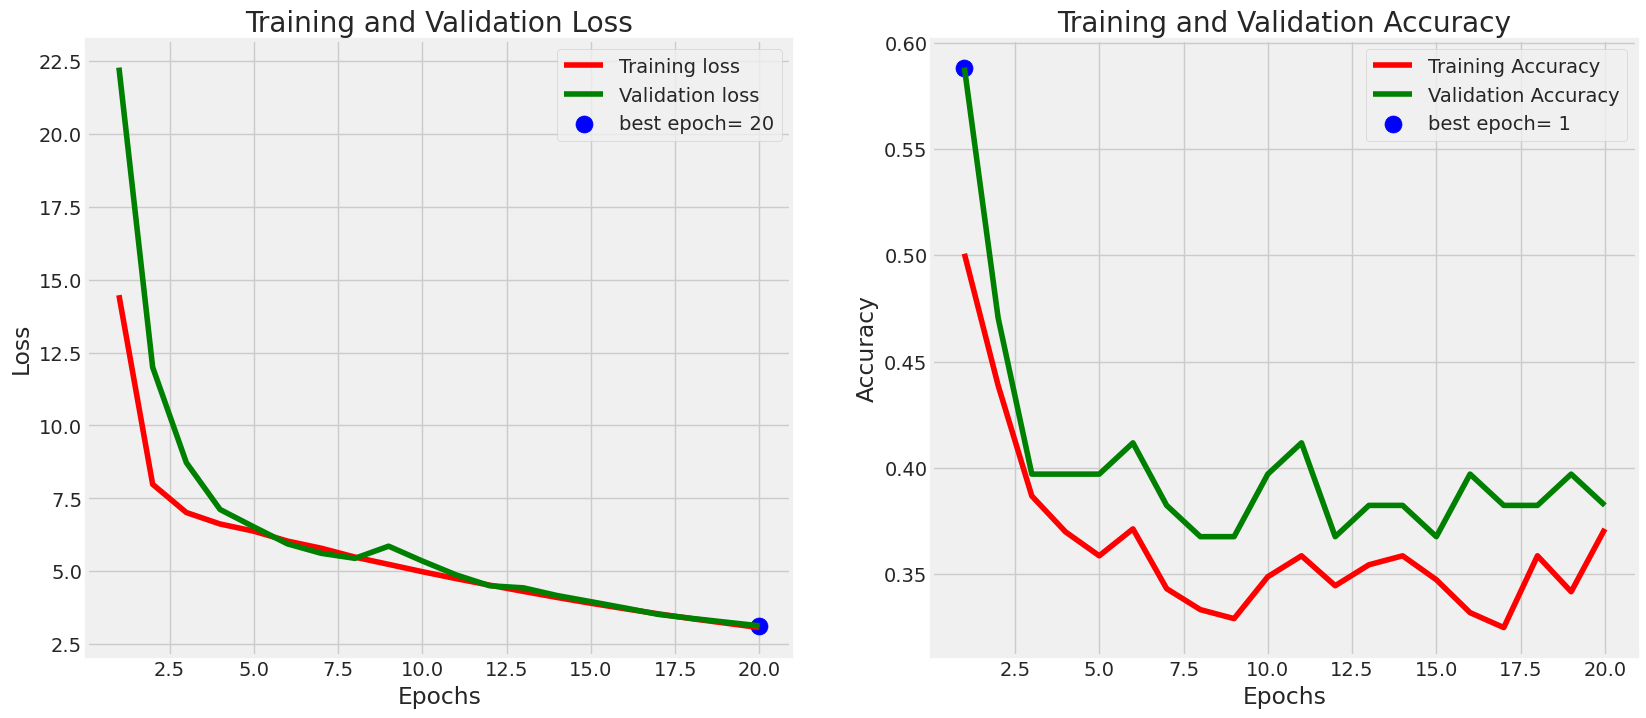

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3750 - loss: 2.9938
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step - accuracy: 0.5625 - loss: 3.0274
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2500 - loss: 2.9951
Train Loss:  2.993823289871216
Train Accuracy:  0.375
--------------------
Validation Loss:  3.0273802280426025
Validation Accuracy:  0.5625
--------------------
Test Loss:  2.9950759410858154
Test Accuracy:  0.25


In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step


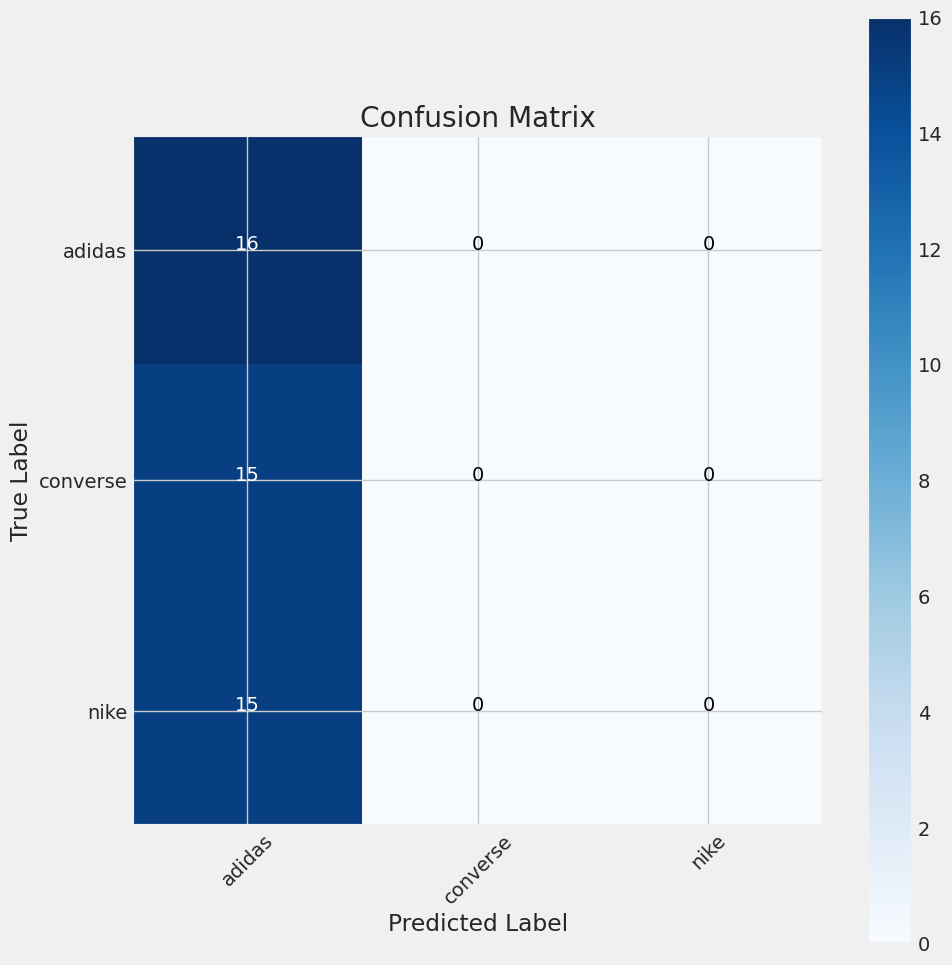

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      adidas       0.35      1.00      0.52        16
    converse       0.00      0.00      0.00        15
        nike       0.00      0.00      0.00        15

    accuracy                           0.35        46
   macro avg       0.12      0.33      0.17        46
weighted avg       0.12      0.35      0.18        46



In [ ]:
#Save the model
model.save('model.h5')